In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import naive_bayes, svm
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

Pipeline   
1. Data loading
2. Preprocessing and encoding
3. Using model for classification (RandomForestClassifier, NaiveBayes and SVM)
4. Saving results

### Load data

In [2]:
data =  pd.read_csv("dataset/train.tsv",sep='\t',header=0)
print(data.head())
X = data['title']
y = data['is_fake'].array

#make sure that there is no class imbalance
print(len(y[y==0])/len(y))

                                               title  is_fake
0  Москвичу Владимиру Клутину пришёл счёт за вмеш...        1
1  Агент Кокорина назвал езду по встречке житейск...        0
2  Госдума рассмотрит возможность введения секрет...        1
3  ФАС заблокировала поставку скоростных трамваев...        0
4  Против Навального завели дело о недоносительст...        1
0.5


###  Preprocessing  (lemmatization and stop words removal)

In [3]:
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(input_text):
    tokens = mystem.lemmatize(input_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation
              and token.find('«') != -1
              and token.find('»') != -1]
    
    input_text = " ".join(tokens)
    
    return input_text

def preprocess_text_with_stopwords(input_text):
    tokens = mystem.lemmatize(input_text.lower())
    tokens = [token for token in tokens if token != " " \
              and token.strip() not in punctuation]
    
    input_text = " ".join(tokens)
    
    return input_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dyush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
preprocess_text_with_stopwords("«Пачка гречки за прививку»: Минздрав объявил о новой акции для пенсионеров")

'« пачка гречка за прививка »:  минздрав объявлять о новый акция для пенсионер'

#### Stemming

In [5]:
def preprocess__stem_text(input_text):
    from nltk.stem.snowball import SnowballStemmer 
    stemmer = SnowballStemmer("russian") 
    tokens = stemmer.stem(input_text.lower())
    stemmed_text = "".join(tokens)
    
    return stemmed_text

In [84]:
X_processed = X.apply(preprocess_text_with_stopwords)
print(X[0])
print(X_processed[0])
df = pd.DataFrame()
df['title'] = X_processed
df.to_csv('processed text with stop words.csv')

Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы
москвич владимир клутин приходить счет за вмешательство в американский выборы


In [111]:
df = pd.read_csv('processed text with stop words.csv')
X = df['title']
X_processed_stemmed = X.apply(preprocess__stem_text)
print(X[0])
print(X_processed_stemmed[0])
df = pd.DataFrame()
df['title'] = X_processed_stemmed
df.to_csv('processed and stemmed with stop words.csv')

москвич владимир клутин приходить счет за вмешательство в американский выборы
москвич владимир клутин приходить счет за вмешательство в американский выбор


### Using only lemmatization without stop words removal show better f1-score results, so I will use this option

In [3]:
df = pd.read_csv('processed text with stop words.csv')
X = df['title']

### Train - test split    

In [4]:
X_raw_train, X_raw_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

###  Count encoding

In [5]:
vectorizer = CountVectorizer() # TfidfVectorizer - another option
X_train = vectorizer.fit_transform(X_raw_train)
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
#dense = vectors.todense() 
X_test = vectorizer.transform(X_raw_test)

['00' '02м' '08м' ... 'яценюк' 'яшин' 'ящик']


ngram ranges (2,2) (1,2) shows worse results so will be used default param value

## 1.RandomForest model:  

In [164]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

print(f1_score(y_test,y_pred))

0.8069852941176471


#### Feature importance:  

навальный      0.012443
запрещать      0.009002
россиянин      0.007381
госдума        0.007305
новый          0.006438
сборная        0.006066
россия         0.005810
выборы         0.005794
депутат        0.005789
российский     0.005256
гражданин      0.005184
байден         0.005057
рпц            0.004929
который        0.004872
лукашенко      0.004864
банк           0.004512
доллар         0.004501
житель         0.004329
обязывать      0.004266
рубль          0.004263
вводить        0.004239
миллиард       0.004215
матч           0.004165
предлагать     0.004066
первый         0.003940
весь           0.003874
сша            0.003858
выходить       0.003835
коронавирус    0.003761
компания       0.003694
dtype: float64


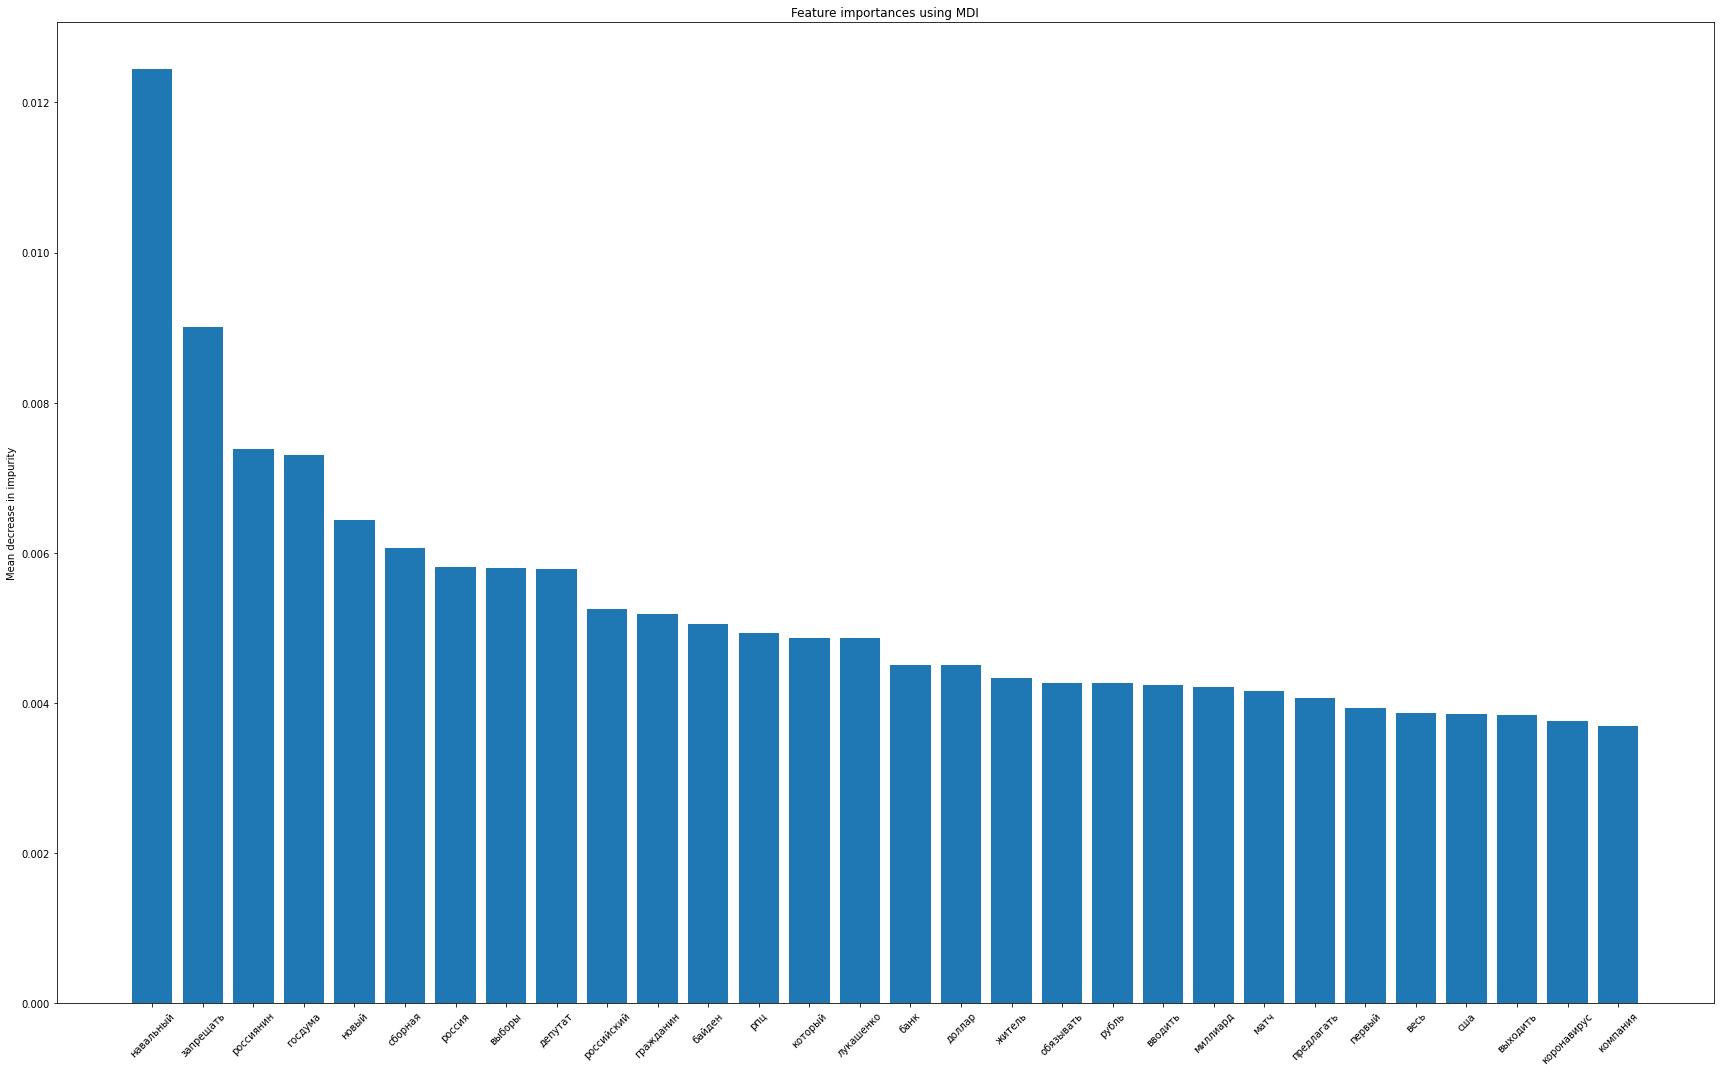

In [7]:
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)
forest_importances = forest_importances[:30]
print(forest_importances)

fig, ax = plt.subplots(figsize = (24,15))
plt.bar(x=forest_importances.index, height=forest_importances)
plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

###  Random Search  

In [35]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1400, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 6, num = 6)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 150, 
                        cv = 3, 
                        verbose = 3, 
                        random_state=0,
                        scoring='f1')
rs.fit(X_train, y_train)
rs.best_params_
joblib.dump(rs, "RFC_random_search_1_leaf_compressed.joblib", compress=3)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
[CV 1/3] END bootstrap=True, max_depth=188, max_features=log2, min_samples_leaf=4, min_samples_split=18, n_estimators=350;, score=0.402 total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=188, max_features=log2, min_samples_leaf=4, min_samples_split=18, n_estimators=350;, score=0.466 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=188, max_features=log2, min_samples_leaf=4, min_samples_split=18, n_estimators=350;, score=0.386 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=455, max_features=sqrt, min_samples_leaf=6, min_samples_split=50, n_estimators=1400;, score=0.730 total time=  19.9s
[CV 2/3] END bootstrap=True, max_depth=455, max_features=sqrt, min_samples_leaf=6, min_samples_split=50, n_estimators=1400;, score=0.775 total time=  20.7s
[CV 3/3] END bootstrap=True, max_depth=455, max_features=sqrt, min_samples_leaf=6, min_samples_split=50, n_estimators=1400;, score=0.761 total time=  20.6s
[CV 

['RFC_random_search_1_leaf_compressed.joblib']

0.8501805054151624


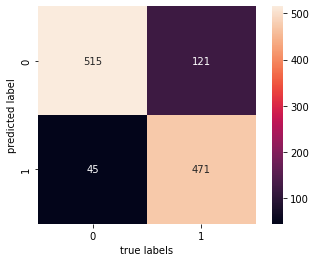

In [36]:
rs = joblib.load("RFC_random_search_1_leaf_compressed.joblib")
print(rs.score(X_test,y_test))
mat = confusion_matrix(y_test,rs.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

#### Feature importance  

навальный     0.008826
на            0.008674
запрещать     0.007210
за            0.006745
госдума       0.006638
быть          0.006514
россиянин     0.006035
из            0.005192
депутат       0.004614
сборная       0.004498
для           0.004495
выборы        0.004255
доллар        0.003971
новый         0.003808
что           0.003801
байден        0.003702
россия        0.003638
гражданин     0.003589
матч          0.003559
который       0.003452
по            0.003443
рпц           0.003442
лукашенко     0.003429
российский    0.003362
обязывать     0.003274
сша           0.003177
предлагать    0.003154
вводить       0.003151
миллиард      0.003108
банк          0.003081
dtype: float64


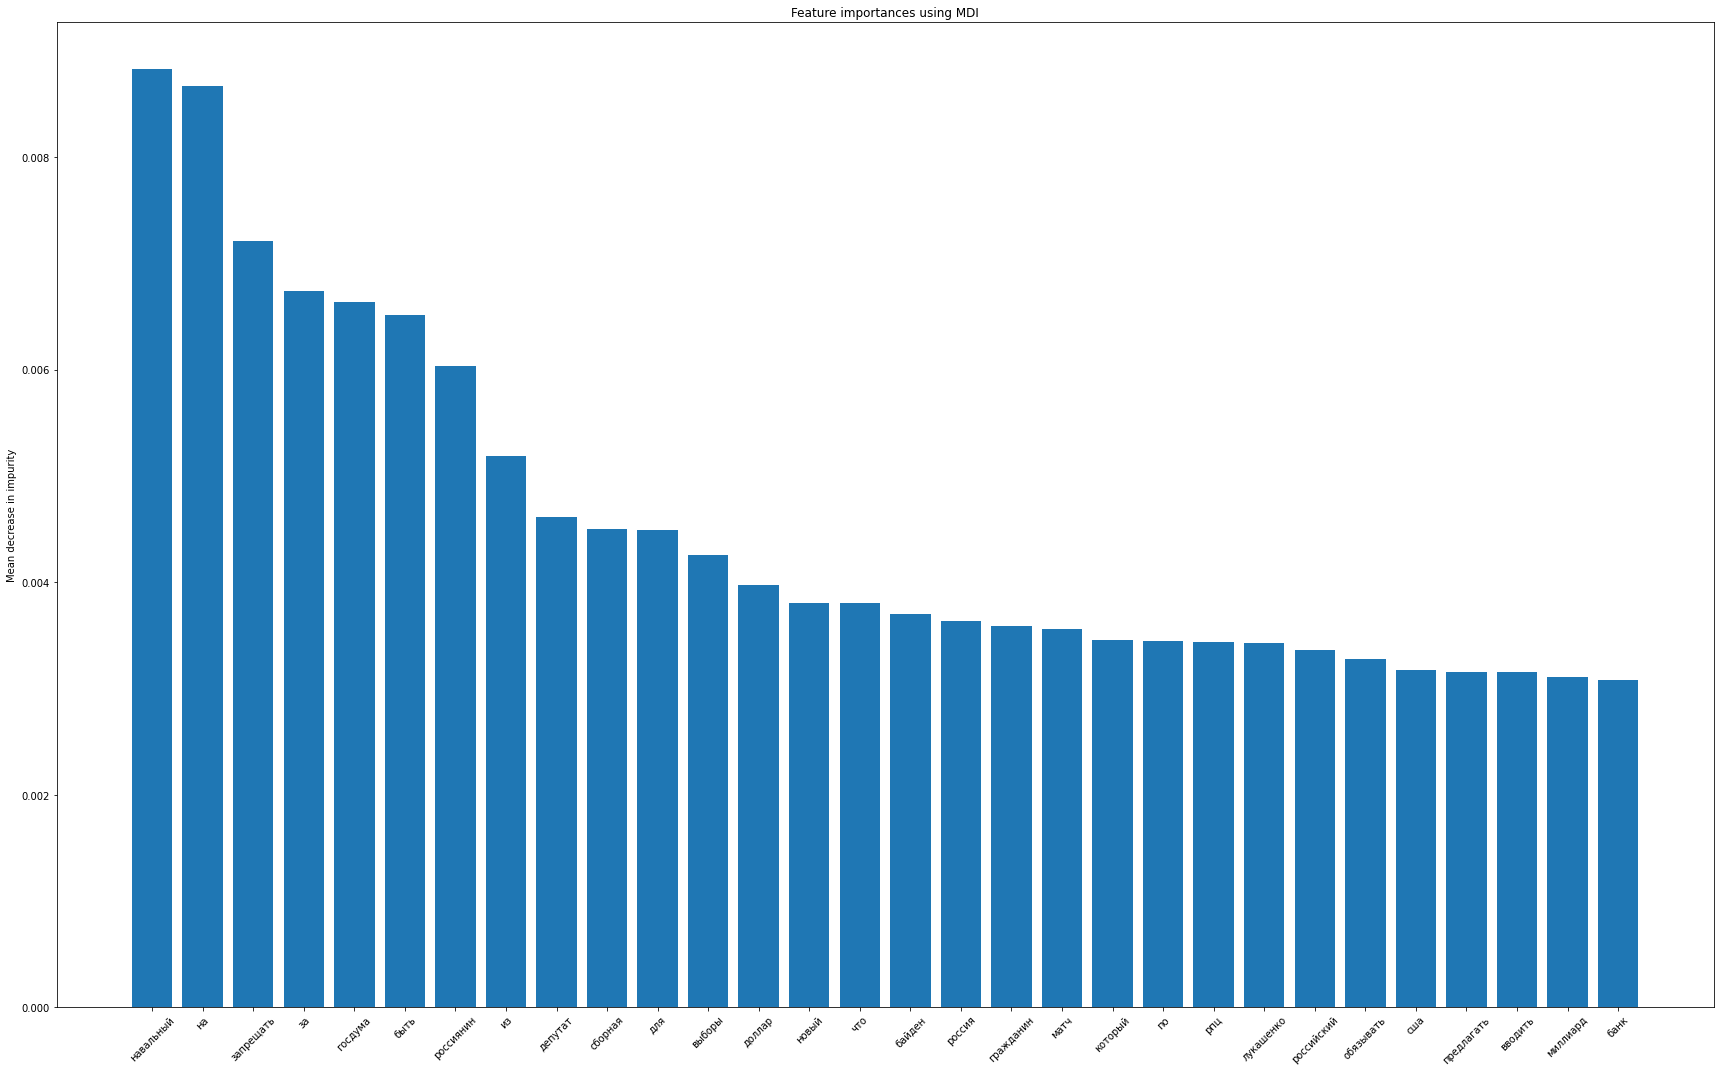

In [39]:
import matplotlib.pyplot as plt
importances = rs.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)
forest_importances = forest_importances[:30]
print(forest_importances)

fig, ax = plt.subplots(figsize = (24,15))
plt.bar(x=forest_importances.index, height=forest_importances)
plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [40]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,800,12,1,log2,322,False,0.841022,1
1,1250,34,1,log2,322,False,0.839859,2
2,350,23,1,log2,144,False,0.835069,3
3,950,50,1,log2,188,True,0.834821,4
4,950,18,1,log2,322,True,0.834689,5
5,1250,7,1,log2,188,True,0.834257,6
6,200,28,1,log2,277,True,0.833771,7
7,200,12,1,log2,322,True,0.831534,8
8,1250,23,1,log2,411,True,0.831471,9
9,1100,34,1,log2,411,True,0.830507,10


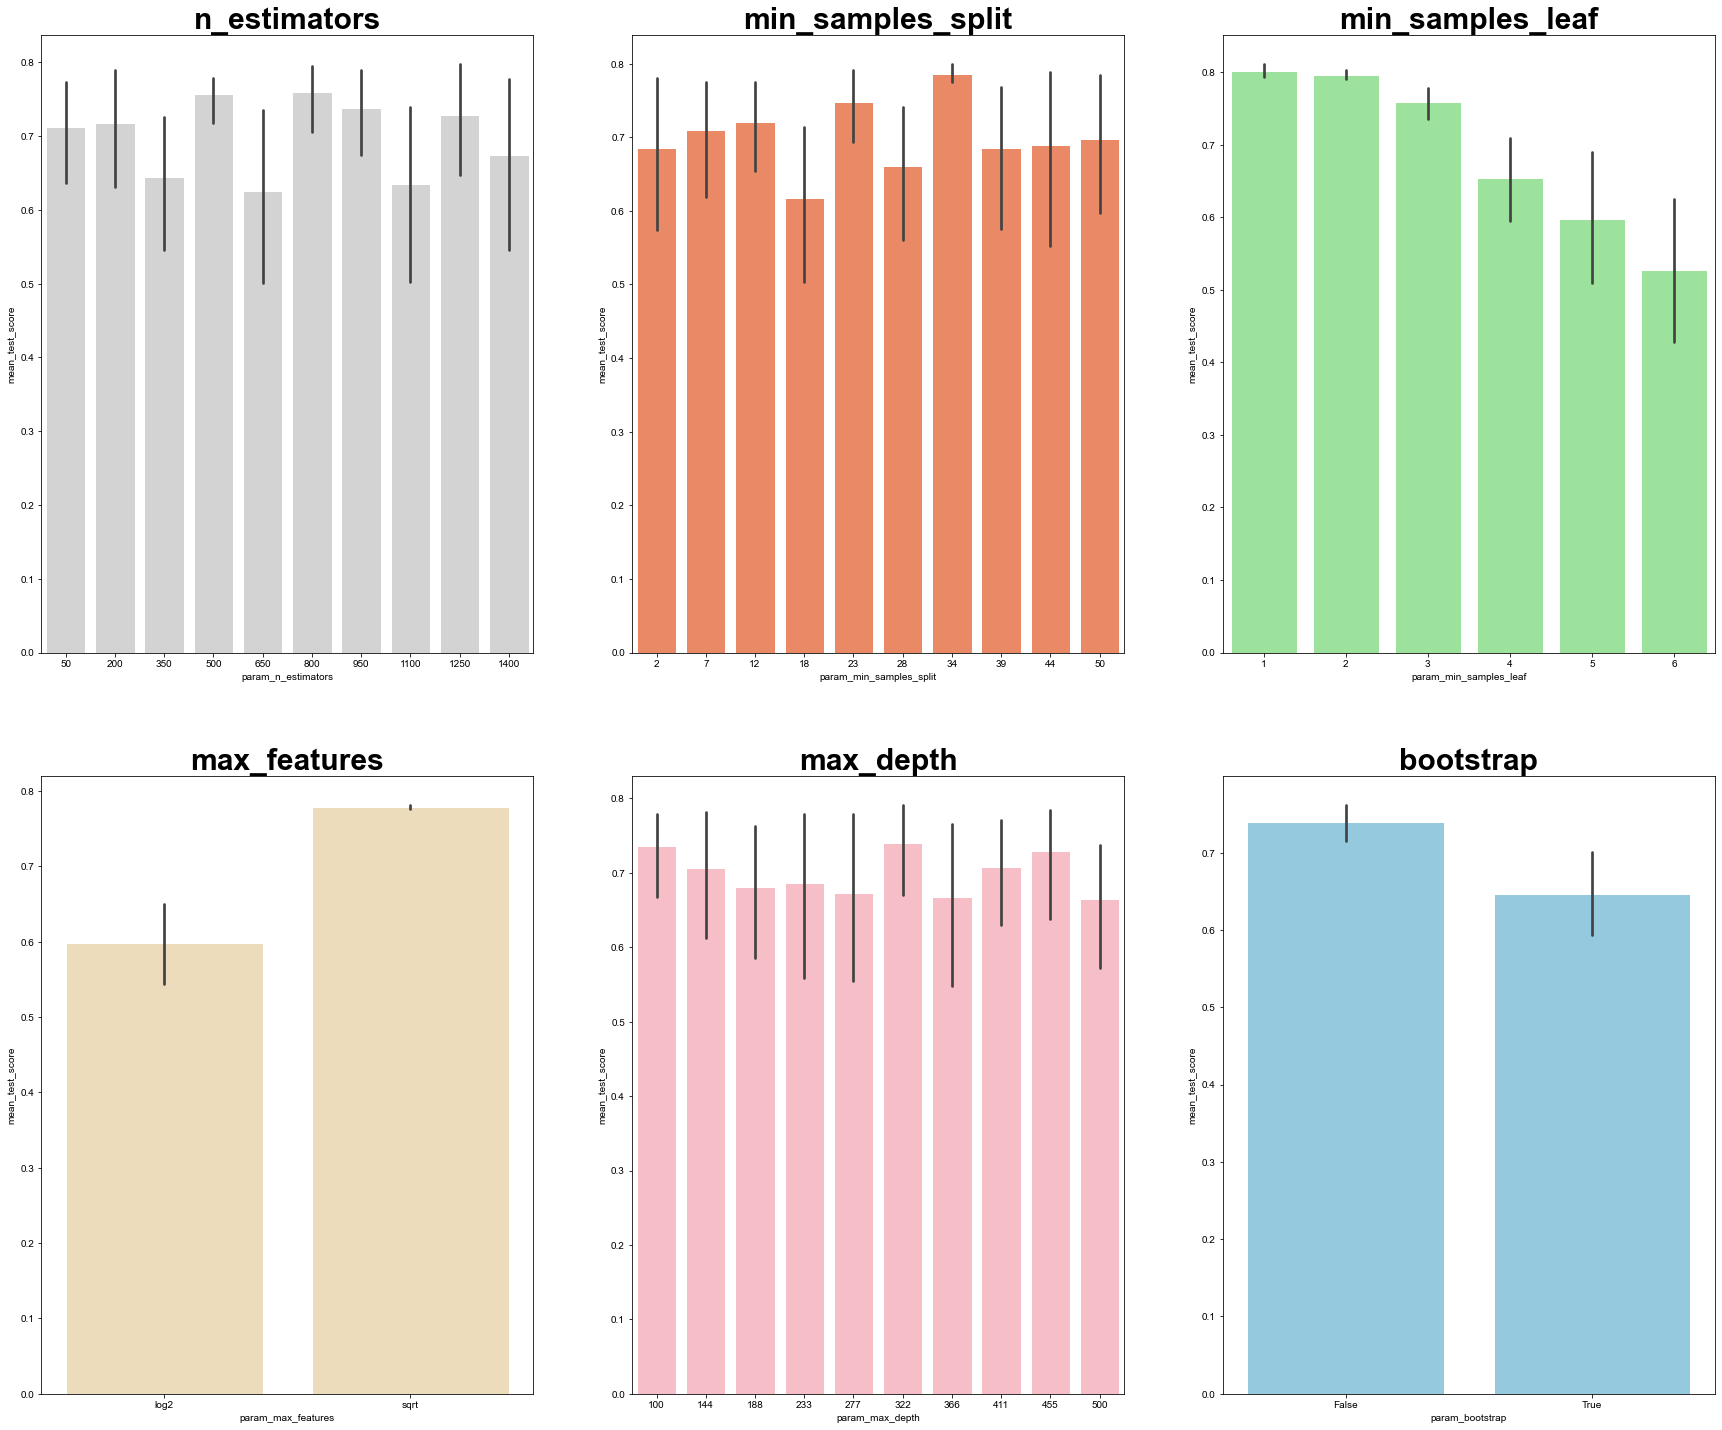

In [41]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim()
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim()
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim()
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim()
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim()
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim()
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

### Grid Search

In [166]:
clf = joblib.load("RFC_random_search_1_leaf_compressed.joblib", mmap_mode=None).best_estimator_
parametrs = {
    'n_estimators': [200,500,800,950,1250],
    'max_depth':[100,322,455],
    'min_samples_split':[12,23,34],
    'min_samples_leaf':[1,2]
}

gs_clf = GridSearchCV(clf,parametrs,cv=3,scoring='f1',verbose=3)
gs_clf.fit(X_train, y_train)
print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
joblib.dump(gs_clf, "rfc_1_leaf_grid_search_compressed.joblib", compress=3)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.801 total time=   6.5s
[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.818 total time=   6.5s
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=200;, score=0.820 total time=   6.3s
[CV 1/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=500;, score=0.799 total time=  16.7s
[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=500;, score=0.823 total time=  18.6s
[CV 3/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=500;, score=0.828 total time=  17.4s
[CV 1/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=800;, score=0.806 total time=  28.3s
[CV 2/3] END max_depth=100, min_samples_leaf=1, min_samples_split=12, n_estimators=800;, score=0.8

['rfc_1_leaf_grid_search_compressed.joblib']

In [6]:
gs_clf = joblib.load("rfc_1_leaf_grid_search_compressed.joblib")
print(gs_clf.score(X_test,y_test))
#from sklearn.metrics import classification_report
#rfc_testing = RandomForestClassifier(bootstrap=False, max_depth=277, max_features='log2',
#                       min_samples_leaf=1, min_samples_split=20,
#                       n_estimators=1100, random_state=0)
#rfc_testing.fit(X_train,y_train)
#y_p = rfc_testing.predict(X_test)
#print(classification_report(y_test, y_p))
#0.8501805054151624 было

0.8656716417910448


####  Feature importance again  

навальный      0.010556
запрещать      0.007909
госдума        0.007342
быть           0.006860
россиянин      0.006367
депутат        0.005448
выборы         0.005211
за             0.005099
который        0.004770
что            0.004699
гражданин      0.004668
байден         0.004596
рпц            0.004438
обязывать      0.004281
из             0.004120
для            0.003993
вводить        0.003936
сборная        0.003854
миллиард       0.003750
лукашенко      0.003735
житель         0.003655
матч           0.003487
коронавирус    0.003357
на             0.003349
предлагать     0.003166
тренер         0.003146
клуб           0.003019
призывать      0.003013
мы             0.002960
вакцина        0.002829
dtype: float64


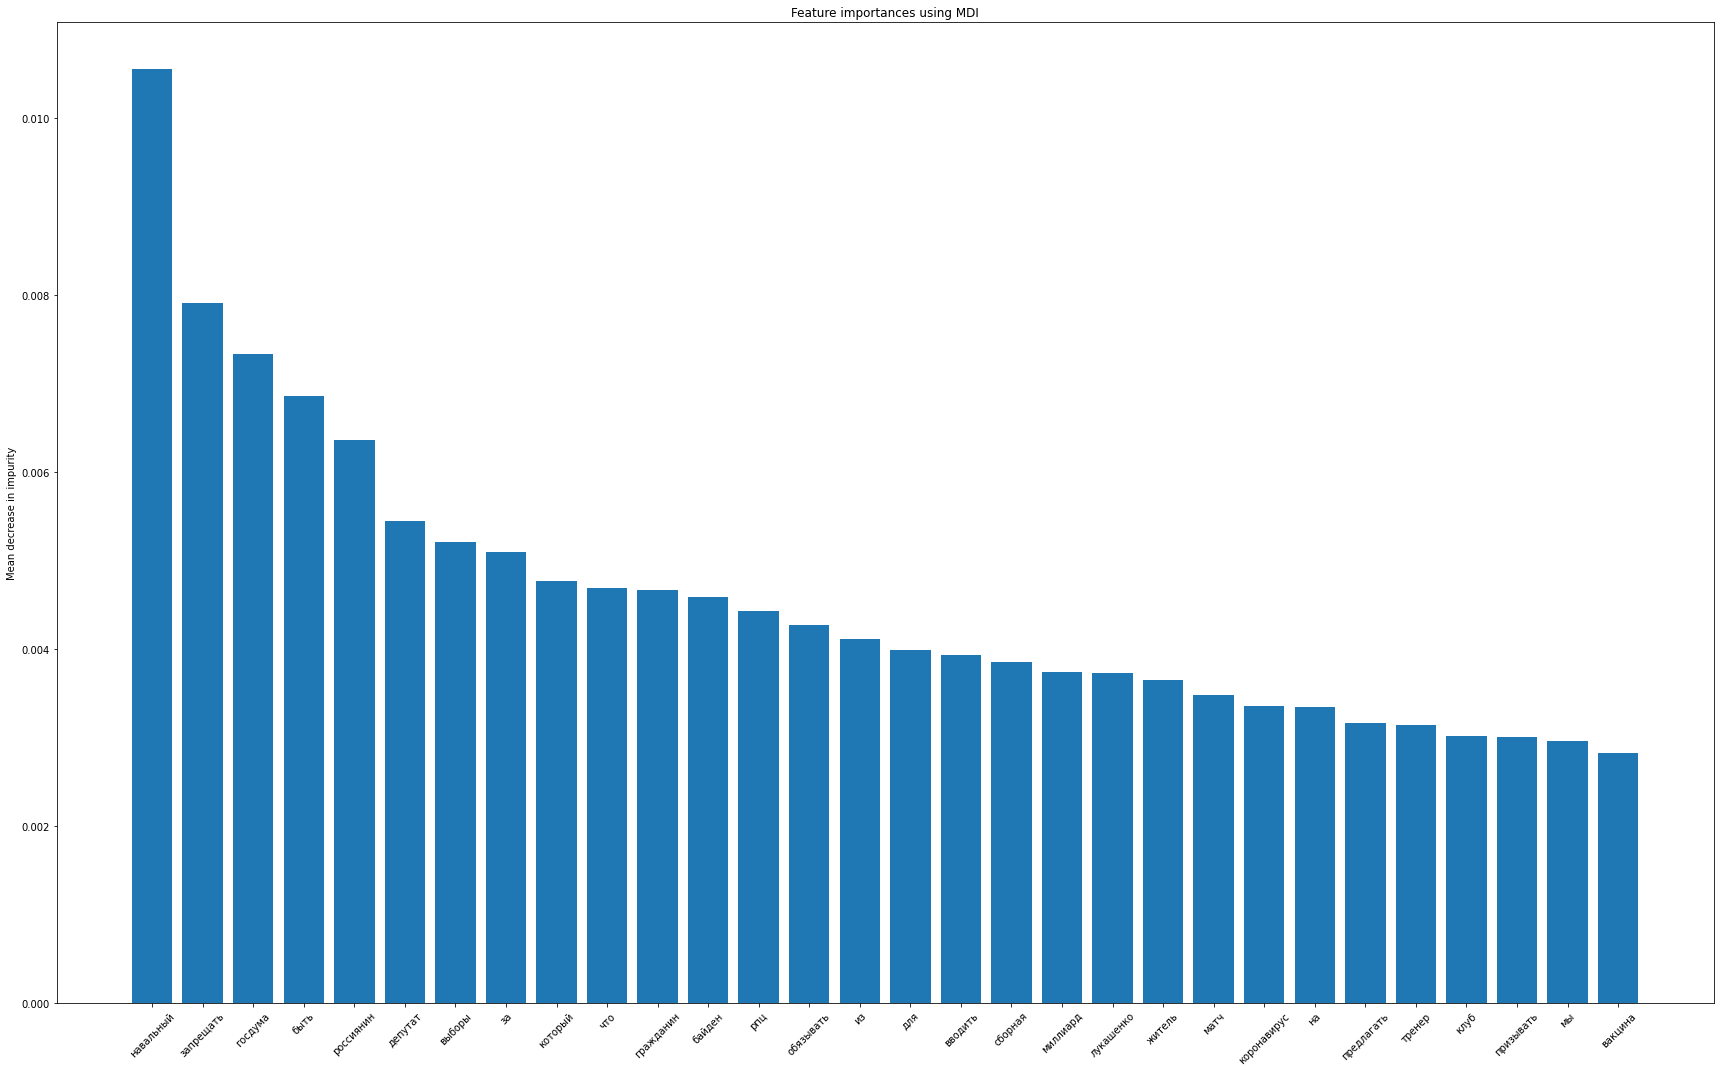

In [7]:
import matplotlib.pyplot as plt
importances = gs_clf.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False,inplace=True)
forest_importances = forest_importances[:30]
print(forest_importances)

fig, ax = plt.subplots(figsize = (24,15))
plt.bar(x=forest_importances.index, height=forest_importances)
plt.xticks(rotation=45)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 2. Support Vector Machine:

In [24]:
SVM = svm.SVC(probability=True)#probability=True required for soft voting classifier
parametrs = {
    'C':[0.75,1.0,1.25,1.5],
    'degree': [2,3,5],
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale','auto']
}

gs_clf_svc = GridSearchCV(SVM,parametrs,cv=3,scoring='f1',verbose=3)
gs_clf_svc.fit(X_train, y_train)
print(gs_clf_svc.best_estimator_)
print(gs_clf_svc.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3] END C=0.75, degree=2, gamma=scale, kernel=linear;, score=0.796 total time=   5.1s
[CV 2/3] END C=0.75, degree=2, gamma=scale, kernel=linear;, score=0.828 total time=   5.2s
[CV 3/3] END C=0.75, degree=2, gamma=scale, kernel=linear;, score=0.825 total time=   5.6s
[CV 1/3] END C=0.75, degree=2, gamma=scale, kernel=poly;, score=0.561 total time=   6.3s
[CV 2/3] END C=0.75, degree=2, gamma=scale, kernel=poly;, score=0.584 total time=   7.0s
[CV 3/3] END C=0.75, degree=2, gamma=scale, kernel=poly;, score=0.558 total time=   6.4s
[CV 1/3] END C=0.75, degree=2, gamma=scale, kernel=rbf;, score=0.817 total time=   5.5s
[CV 2/3] END C=0.75, degree=2, gamma=scale, kernel=rbf;, score=0.834 total time=   5.7s
[CV 3/3] END C=0.75, degree=2, gamma=scale, kernel=rbf;, score=0.839 total time=   5.7s
[CV 1/3] END C=0.75, degree=2, gamma=scale, kernel=sigmoid;, score=0.791 total time=   5.0s
[CV 2/3] END C=0.75, degree=2, gamma=scale

In [25]:
print(gs_clf_svc.score(X_test,y_test))

0.8095693779904306


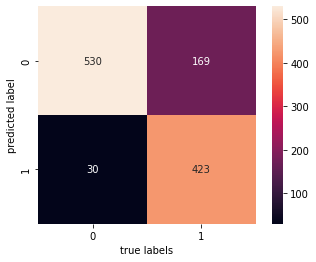

In [26]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,gs_clf_svc.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

## 3. Naive bayes

### Fine tune alpha and fit_prior params

In [27]:
clf = naive_bayes.MultinomialNB()
parametrs = {
    'alpha':[0.001,0.05,0.01,0.45,0.5,0.75,1],
    'fit_prior':[False,True]
}
gs_mnb_clf = GridSearchCV(clf,parametrs,cv=3,scoring='f1')
gs_mnb_clf.fit(X_train, y_train)
print("cv = 3: ",gs_mnb_clf.best_params_)
print(gs_mnb_clf.score(X_test,y_test))

gs_mnb_clf = GridSearchCV(clf,parametrs,cv=10,scoring='f1')
gs_mnb_clf.fit(X_train, y_train)
print("cv = 10: ",gs_mnb_clf.best_params_)
print(gs_mnb_clf.score(X_test,y_test))

cv = 3:  {'alpha': 0.45, 'fit_prior': True}
0.8776508972267536
cv = 10:  {'alpha': 0.5, 'fit_prior': True}
0.8776508972267536


### Let's compare confusion matricies  

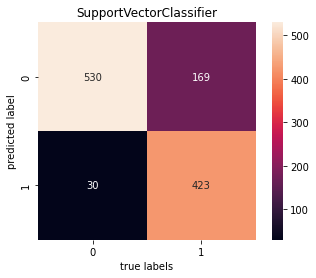

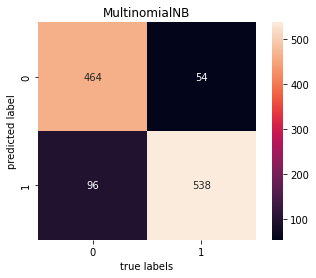

In [28]:
from sklearn.metrics import confusion_matrix


mat = confusion_matrix(y_test,gs_clf_svc.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.title("SupportVectorClassifier")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

mat = confusion_matrix(y_test,gs_mnb_clf.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.title("MultinomialNB")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

### Let's use voting classifer: models architecture different so results should be better 

In [29]:
eclf = VotingClassifier(estimators=[('svc', gs_clf_svc.best_estimator_), ('mnb', gs_mnb_clf.best_estimator_)],voting='soft')
eclf = eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)
print(f1_score(y_test,y_pred))
print(cross_val_score(eclf,X_train,y_train,cv=3,scoring='f1').mean())

0.8898525585429314
0.8718274147325612


Yes! That is true.

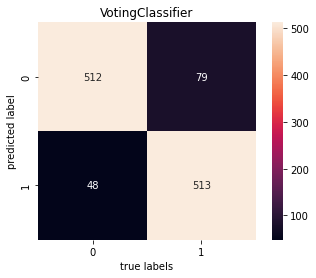

In [30]:
mat = confusion_matrix(y_test,eclf.predict(X_test))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.title("VotingClassifier")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

## Make test predictions with best model 

In [31]:
data =  pd.read_csv("dataset/test.tsv",sep='\t',header=0)
print(data.head())
X_source_test = data['title']
X_source_test.head()

                                               title  is_fake
0  Роскомнадзор представил реестр сочетаний цвето...        0
1  Ночью под Минском на президентской горе Белара...        0
2  Бывший спичрайтер Юрия Лозы рассказал о трудно...        0
3  Сельская церковь, собравшая рекордно низкое ко...        0
4  Акции Google рухнули после объявления о переза...        0


0    Роскомнадзор представил реестр сочетаний цвето...
1    Ночью под Минском на президентской горе Белара...
2    Бывший спичрайтер Юрия Лозы рассказал о трудно...
3    Сельская церковь, собравшая рекордно низкое ко...
4    Акции Google рухнули после объявления о переза...
Name: title, dtype: object

####  String processing and Tf-idf again

In [ ]:
X_test_processed = X_source_test.apply(preprocess_text_with_stopwords)
df = pd.DataFrame()
df['title'] = X_test_processed
df.to_csv('processed stemmed test text with stop words.csv')

In [32]:
X_test_processed = pd.read_csv('processed stemmed test text with stop words.csv')['title']
X_test_processed.head()

0    роскомнадзор представлять реестр сочетание цве...
1    ночь под минск на президентский гора беларашмо...
2    бывший спичрайтер юрий лоза рассказывать о тру...
3    сельский церковь собирать рекордно низкий коли...
4    акция google рухнуть после объявление о переза...
Name: title, dtype: object

In [33]:
vectorizer = CountVectorizer()
X_all = vectorizer.fit_transform(X)
feature_names = vectorizer.get_feature_names()
X_test = vectorizer.transform(X_test_processed)

C:\Users\dyush\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Apply model and make predictions  (best f1-score - Voting Classifier (SVC + MNB))

In [34]:
eclf.fit(X_all,y)

VotingClassifier(estimators=[('svc', SVC(C=1.5, degree=2, probability=True)),
                             ('mnb', MultinomialNB(alpha=0.5))],
                 voting='soft')

In [35]:
y_pred = eclf.predict(X_test)

####  Wtite prediction results:  

In [37]:
data['is_fake'] = y_pred
data.to_csv("dataset/predictions.tsv",sep='\t',index=False)